In [5]:
import csv
from pathlib import Path
import os

def write_to_csv_parameters(filename):
    fieldnames = ['Date', 'Item Name', 'p', 'd', 'q']
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        writer.writerow(fieldnames)
        
        # writer.writerow([today_date, product_name, p, d, q])
        
base_dir = Path(os.getenv("BASE_DIRECTORY"))
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
write_to_csv_parameters(filename)

         Date Item Name  Low Price  Average Price  High Price
0  20-11-2024     જામફળ        500            800        1100
1  20-11-2024      દાડમ        800           1000        1200
2  20-11-2024     સફરજન       1000           1500        2000
3  20-11-2024    પોપૈયા        400            450         500
4  20-11-2024    સીતાફળ        400            700        1000
['જામફળ' 'દાડમ' 'સફરજન' 'પોપૈયા' 'સીતાફળ' 'સંતરા' 'સ્ટ્રોબેરી' 'ક્મલમ'
 'મોસંબી' 'ટેટી' 'દ્રાક્ષ' 'કીવી' 'આલુચા' 'કેળા' 'તરબૂચ' 'ગુલાબ' 'અનાનસ'
 'માલટા' 'બોર' 'ચીકુ' 'આબલી' 'લિચી' 'કેસર કેરી' 'ઓરેંજ' 'હાફુસ કેરી'
 'લાલબાગ કેરી' 'બદામ કેરી' 'સૂ્દરી કેરી']
Data older than 21-11-2024 has been removed.
જામફળ size:  112
False
Checking stationarity for the raw price data of જામફળ:

ADF Test Results:
ADF Statistic: -7.1311
p-value: 0.0000
Critical Value 1%: -3.4907
Critical Value 5%: -2.8880
Critical Value 10%: -2.5809
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity

<Figure size 1200x600 with 0 Axes>

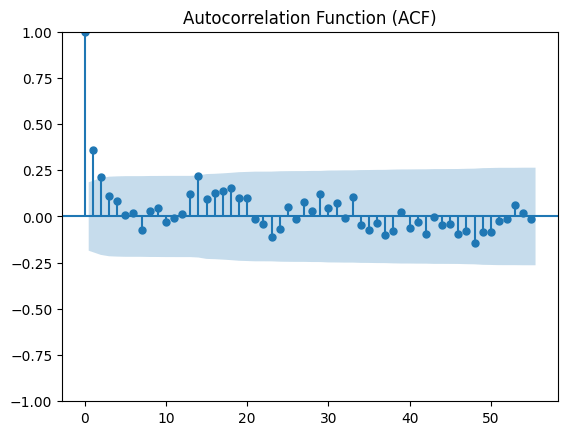

<Figure size 1200x600 with 0 Axes>

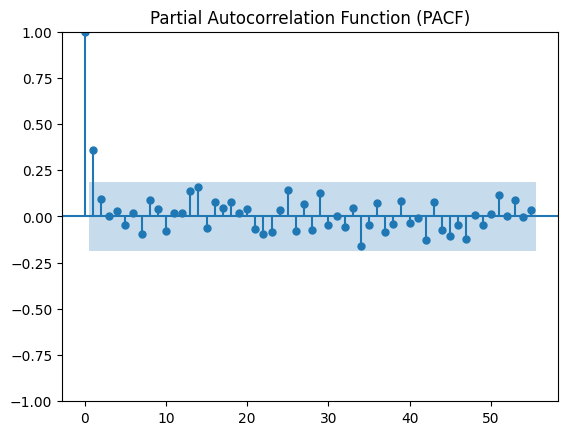


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  112
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -696.066
Date:                Fri, 21 Mar 2025   AIC                           1398.132
Time:                        19:54:33   BIC                           1406.288
Sample:                             0   HQIC                          1401.441
                                - 112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        707.7511     18.657     37.935      0.000     671.184     744.318
ar.L1          0.3613      0.09

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

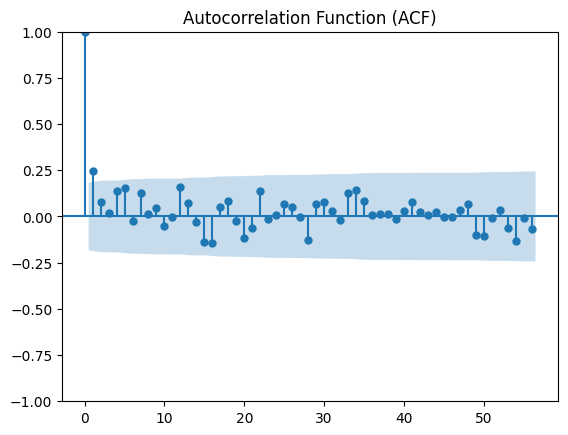

<Figure size 1200x600 with 0 Axes>

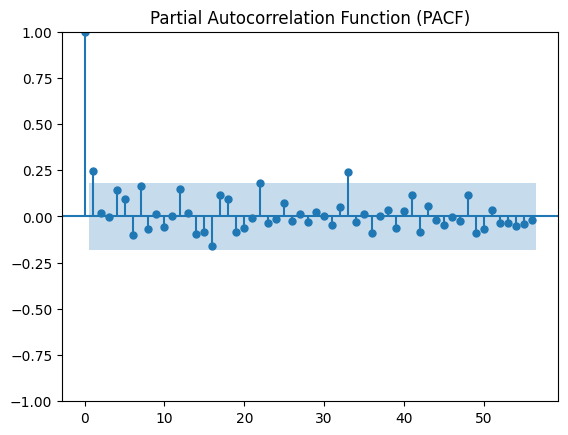


Fitting ARIMA model with order (5, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  115
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -795.818
Date:                Fri, 21 Mar 2025   AIC                           1611.637
Time:                        19:54:43   BIC                           1639.086
Sample:                             0   HQIC                          1622.778
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1134.8339     50.392     22.520      0.000    1036.067    1233.601
ar.L1         -0.5426      0.267     -2.029      0.042      -1.067      -0.0

<Figure size 1200x600 with 0 Axes>

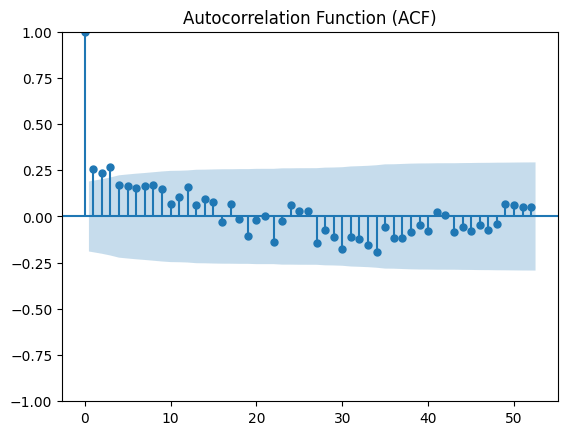

<Figure size 1200x600 with 0 Axes>

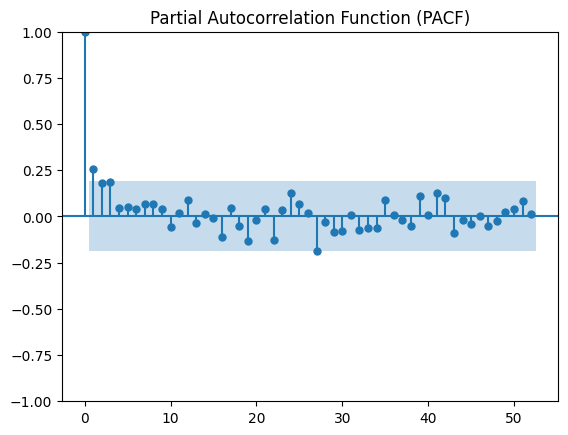


Fitting ARIMA model with order (2, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  107
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -774.458
Date:                Fri, 21 Mar 2025   AIC                           1556.916
Time:                        19:54:45   BIC                           1567.607
Sample:                             0   HQIC                          1561.250
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2052.4378     54.301     37.797      0.000    1946.009    2158.867
ar.L1          0.2145      0.088      2.435      0.015       0.042       0.3

<Figure size 1200x600 with 0 Axes>

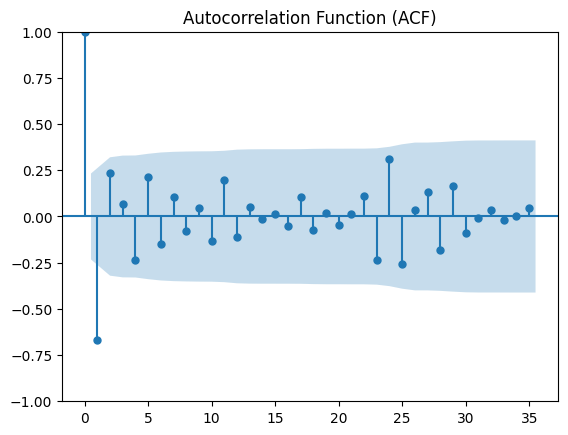

<Figure size 1200x600 with 0 Axes>

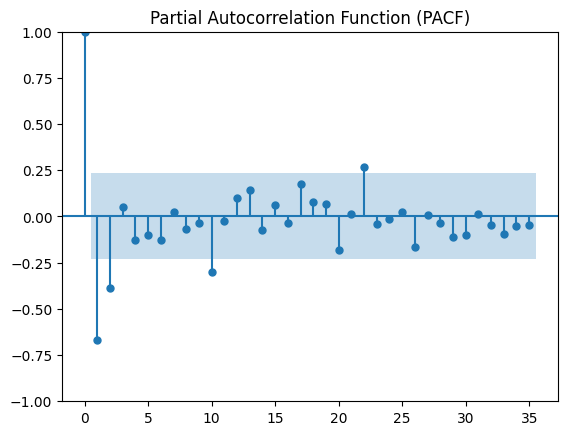


Fitting ARIMA model with order (2, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   72
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -409.433
Date:                Fri, 21 Mar 2025   AIC                            828.866
Time:                        19:54:48   BIC                            840.180
Sample:                             0   HQIC                           833.365
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4180      0.143     -9.893      0.000      -1.699      -1.137
ar.L2         -0.5285      0.182     -2.909      0.004      -0.885      -0.1

<Figure size 1200x600 with 0 Axes>

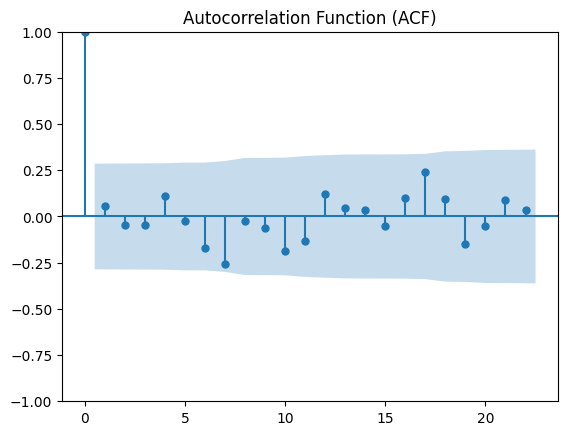

<Figure size 1200x600 with 0 Axes>

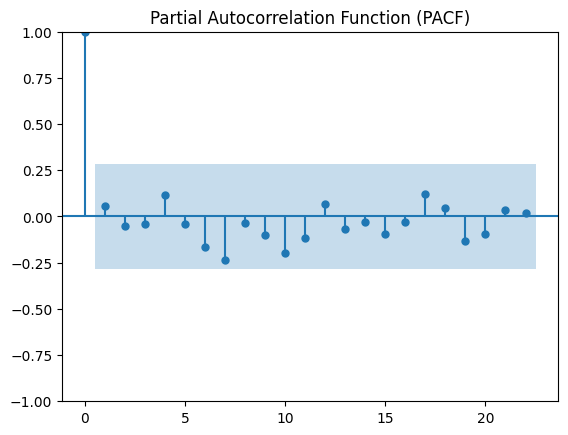


Fitting ARIMA model with order (5, 0, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   47
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -293.338
Date:                Fri, 21 Mar 2025   AIC                            606.675
Time:                        19:54:54   BIC                            625.177
Sample:                             0   HQIC                           613.637
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        789.4863     24.513     32.206      0.000     741.441     837.531
ar.L1          0.3123      0.731      0.427      0.669      -1.120       1.7

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

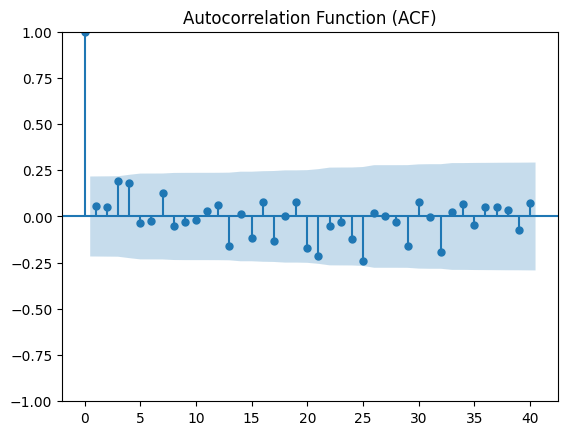

<Figure size 1200x600 with 0 Axes>

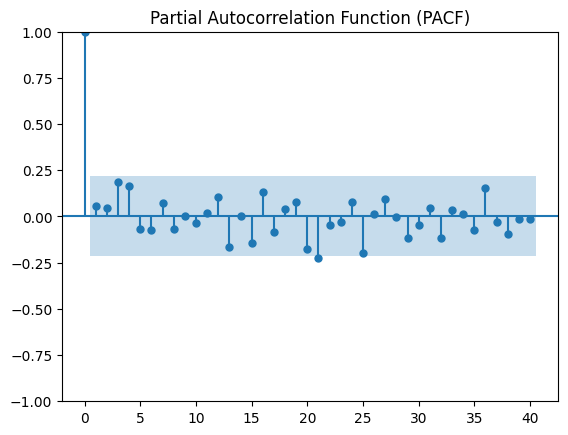


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   82
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -643.810
Date:                Fri, 21 Mar 2025   AIC                           1301.620
Time:                        19:54:55   BIC                           1318.467
Sample:                             0   HQIC                          1308.383
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1088.6867    120.705      9.019      0.000     852.108    1325.265
ar.L1          1.6582      0.311      5.339      0.000       1.049       2.2

<Figure size 1200x600 with 0 Axes>

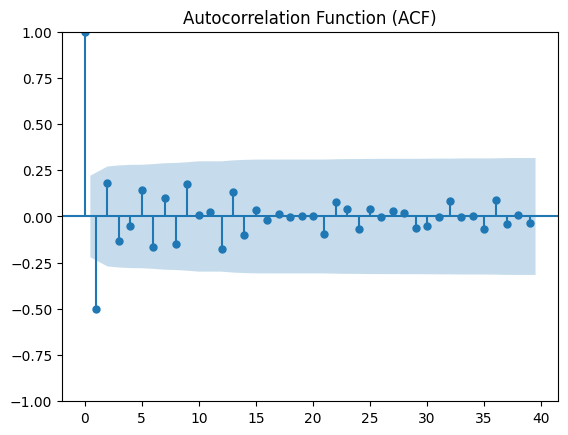

<Figure size 1200x600 with 0 Axes>

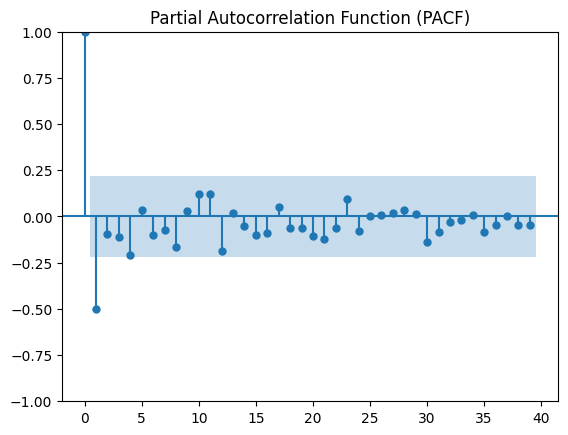


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -580.313
Date:                Fri, 21 Mar 2025   AIC                           1178.626
Time:                        19:54:57   BIC                           1199.951
Sample:                             0   HQIC                          1187.169
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1476      0.392     -0.377      0.706      -0.915       0.620
ar.L2          0.9284      0.406      2.288      0.022       0.133       1.7

<Figure size 1200x600 with 0 Axes>

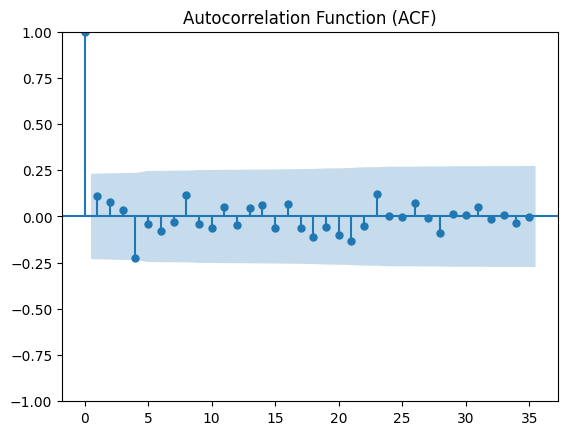

<Figure size 1200x600 with 0 Axes>

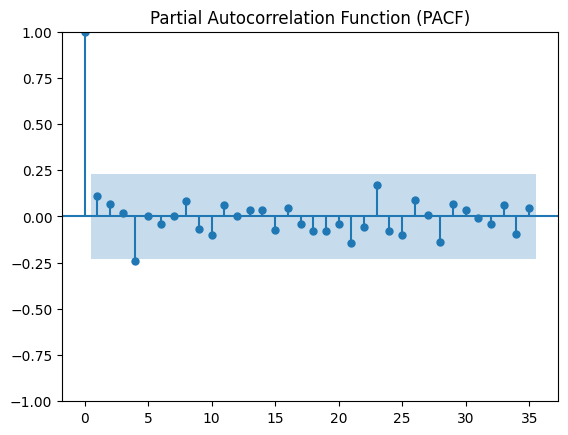


Fitting ARIMA model with order (2, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   72
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -531.322
Date:                Fri, 21 Mar 2025   AIC                           1072.643
Time:                        19:54:58   BIC                           1084.027
Sample:                             0   HQIC                          1077.175
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1806.9523   1014.361      1.781      0.075    -181.158    3795.063
ar.L1          0.6840      0.75

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

Model for ક્મલમ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_df33c820fdd3bd9f139d948554d1e813.pkl
મોસંબી size:  80
True
Checking stationarity for the raw price data of મોસંબી:

ADF Test Results:
ADF Statistic: -2.0462
p-value: 0.2667
Critical Value 1%: -3.5195
Critical Value 5%: -2.9004
Critical Value 10%: -2.5875
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.3156
p-value: 0.0000
Critical Value 1%: -3.5195
Critical Value 5%: -2.9004
Critical Value 10%: -2.5875
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.3156
p-value: 0.0000
Critical Value 1%: -3.5195
Critical Value 5%: -2.9004
Critical Value 10%: -2.5875
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 5 at lags [ 1  5 10 14 17]
Significant spikes in PACF (p): 8 at lags [ 1  2  3  5  6  7  8

<Figure size 1200x600 with 0 Axes>

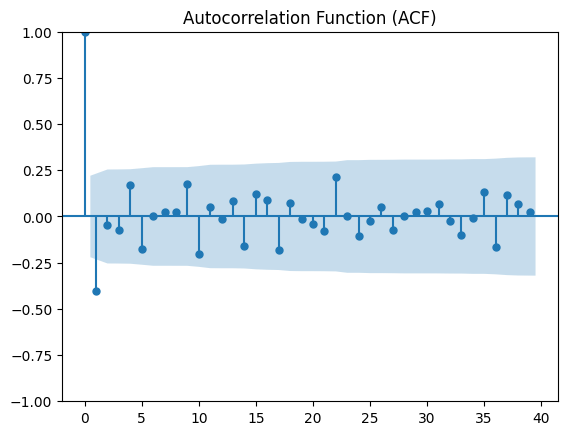

<Figure size 1200x600 with 0 Axes>

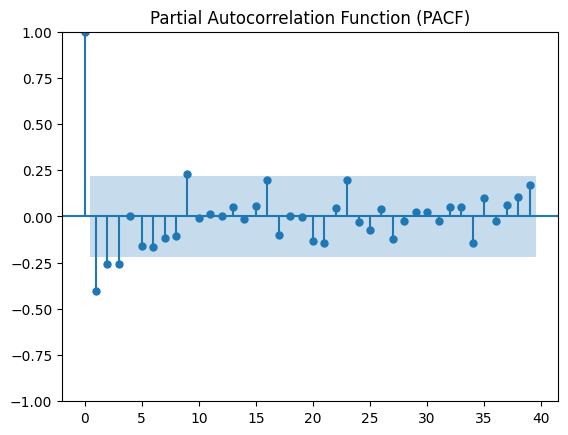


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   80
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -482.671
Date:                Fri, 21 Mar 2025   AIC                            987.343
Time:                        19:54:59   BIC                           1013.407
Sample:                             0   HQIC                           997.785
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8680      0.193     -4.497      0.000      -1.246      -0.490
ar.L2         -0.8445      0.330     -2.562      0.010      -1.491      -0.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

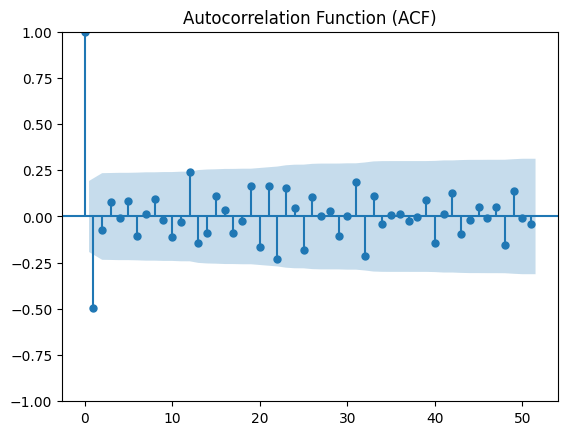

<Figure size 1200x600 with 0 Axes>

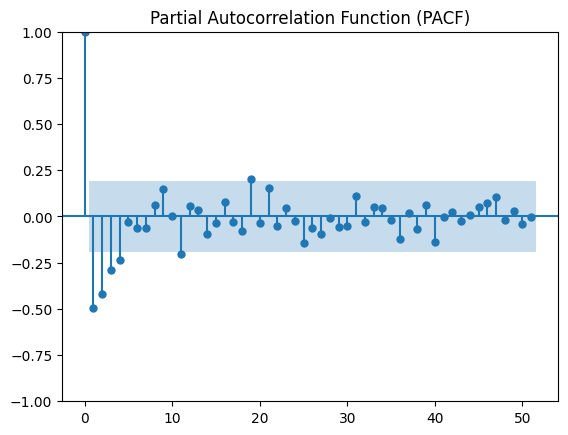


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  105
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -611.564
Date:                Fri, 21 Mar 2025   AIC                           1237.129
Time:                        19:55:01   BIC                           1255.639
Sample:                             0   HQIC                          1244.628
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4583      0.179      8.141      0.000       1.107       1.809
ar.L2         -0.6446      0.222     -2.900      0.004      -1.080      -0.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

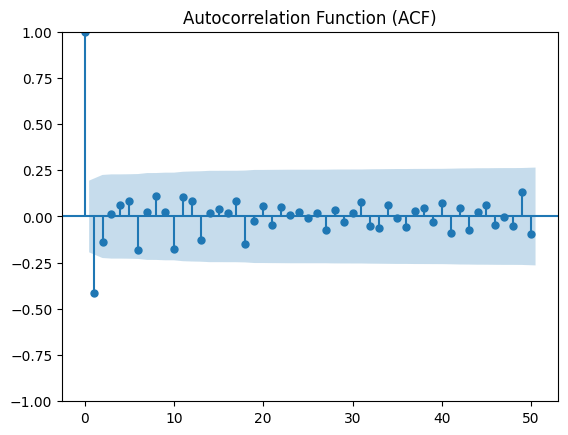

<Figure size 1200x600 with 0 Axes>

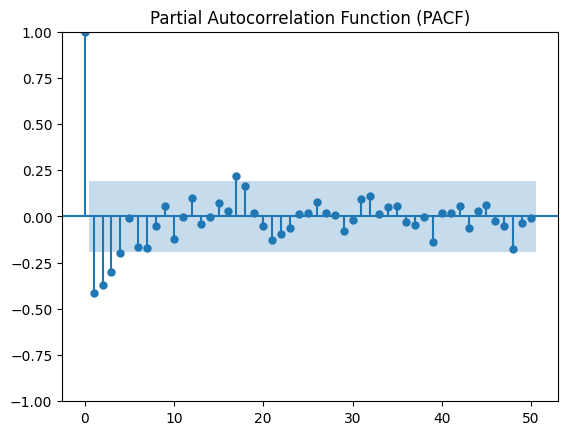


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  103
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -845.765
Date:                Fri, 21 Mar 2025   AIC                           1713.529
Time:                        19:55:02   BIC                           1742.404
Sample:                             0   HQIC                          1725.222
                                - 103                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3165      0.064     -4.952      0.000      -0.442      -0.191
ar.L2         -0.2100      0.057     -3.690      0.000      -0.321      -0.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

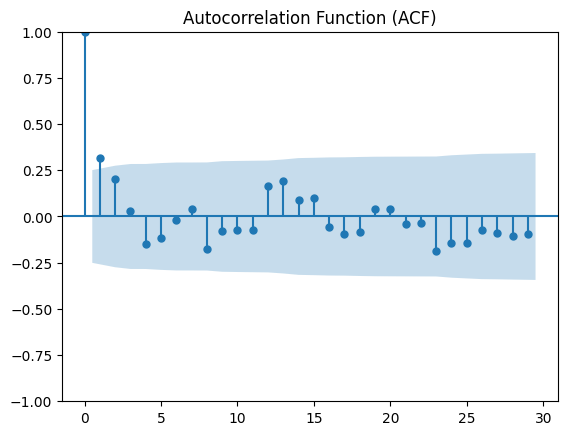

<Figure size 1200x600 with 0 Axes>

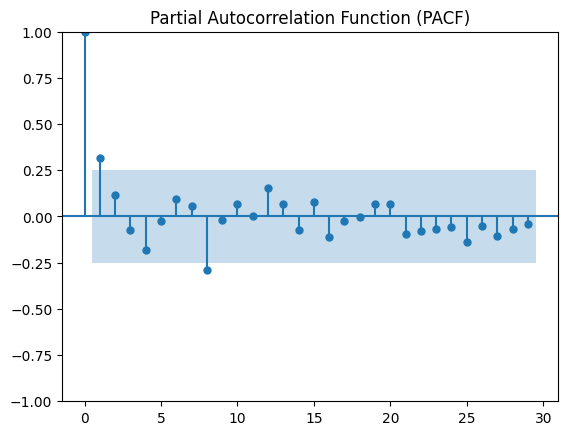


Fitting ARIMA model with order (3, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   61
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -482.077
Date:                Fri, 21 Mar 2025   AIC                            978.153
Time:                        19:55:04   BIC                            992.929
Sample:                             0   HQIC                           983.944
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5322.5069    166.813     31.907      0.000    4995.559    5649.455
ar.L1          0.4309      0.163      2.648      0.008       0.112       0.7

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

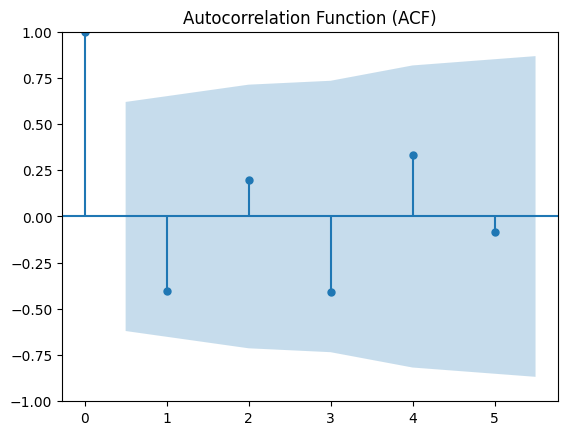

<Figure size 1200x600 with 0 Axes>

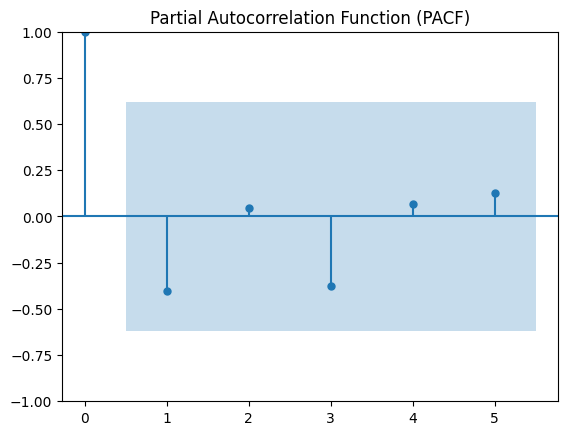


Fitting ARIMA model with order (2, 3, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   13
Model:                 ARIMA(2, 3, 2)   Log Likelihood                   0.000
Date:                Fri, 21 Mar 2025   AIC                             10.000
Time:                        19:55:04   BIC                             11.513
Sample:                             0   HQIC                             8.340
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0954         -0        inf      0.000      -0.095      -0.095
ar.L2         -0.0764         -

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

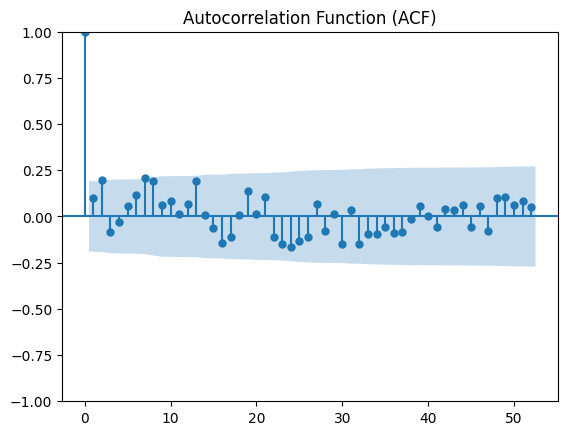

<Figure size 1200x600 with 0 Axes>

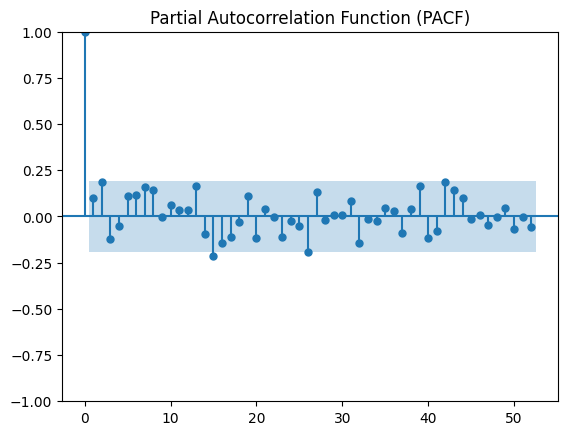


Fitting ARIMA model with order (1, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  106
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -491.537
Date:                Fri, 21 Mar 2025   AIC                            991.074
Time:                        19:55:05   BIC                           1001.728
Sample:                             0   HQIC                           995.392
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        499.4195      5.684     87.864      0.000     488.279     510.560
ar.L1          0.9353      0.09

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for કેળા saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_3dc2f98f51a08642643cd7e1aaa6f7bf.pkl
તરબૂચ size:  92
False
Checking stationarity for the raw price data of તરબૂચ:

ADF Test Results:
ADF Statistic: -1.0086
p-value: 0.7501
Critical Value 1%: -3.5061
Critical Value 5%: -2.8946
Critical Value 10%: -2.5844
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -9.5488
p-value: 0.0000
Critical Value 1%: -3.5061
Critical Value 5%: -2.8946
Critical Value 10%: -2.5844
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -9.5488
p-value: 0.0000
Critical Value 1%: -3.5061
Critical Value 5%: -2.8946
Critical Value 10%: -2.5844
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [ 1  4 19]
Significant spikes in PACF (p): 5 at lags [ 1  2  4  7 17]


<Figure size 1200x600 with 0 Axes>

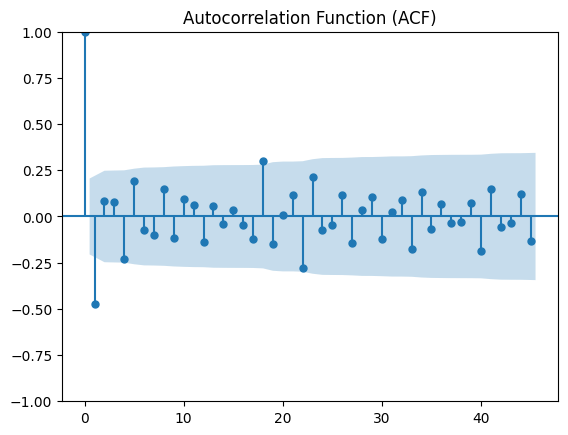

<Figure size 1200x600 with 0 Axes>

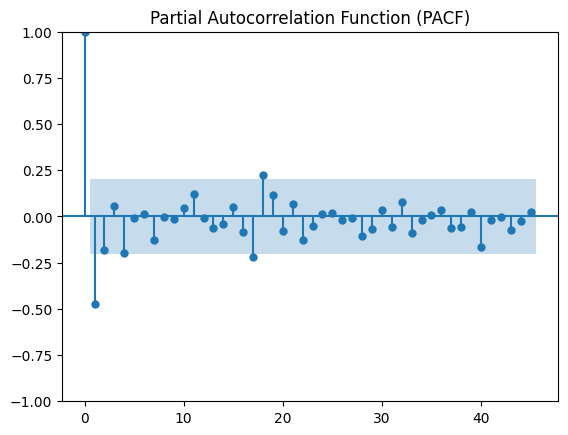


Fitting ARIMA model with order (5, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   92
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -414.178
Date:                Fri, 21 Mar 2025   AIC                            846.356
Time:                        19:55:06   BIC                            868.954
Sample:                             0   HQIC                           855.473
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6627      0.648     -1.023      0.306      -1.932       0.606
ar.L2         -0.4488      0.930     -0.483      0.629      -2.271       1.3

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

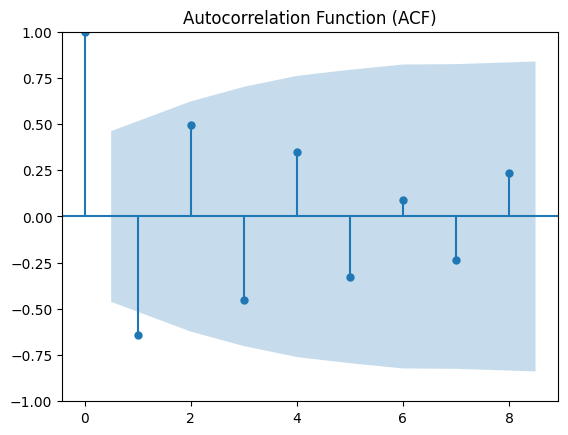

<Figure size 1200x600 with 0 Axes>

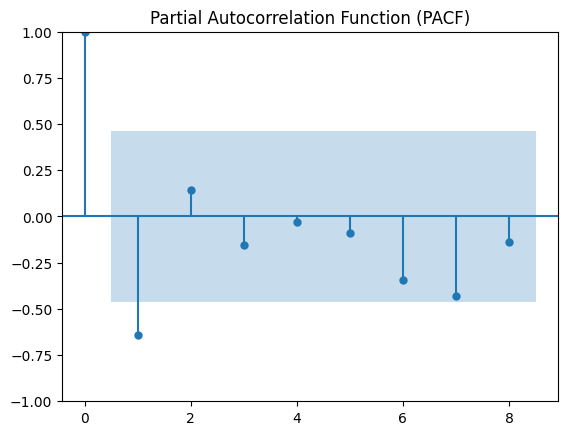


Fitting ARIMA model with order (3, 1, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   19
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -152.367
Date:                Fri, 21 Mar 2025   AIC                            316.735
Time:                        19:55:07   BIC                            322.077
Sample:                             0   HQIC                           317.472
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7831      0.290     -2.697      0.007      -1.352      -0.214
ar.L2          0.6133      0.418      1.468      0.142      -0.205       1.4

<Figure size 1200x600 with 0 Axes>

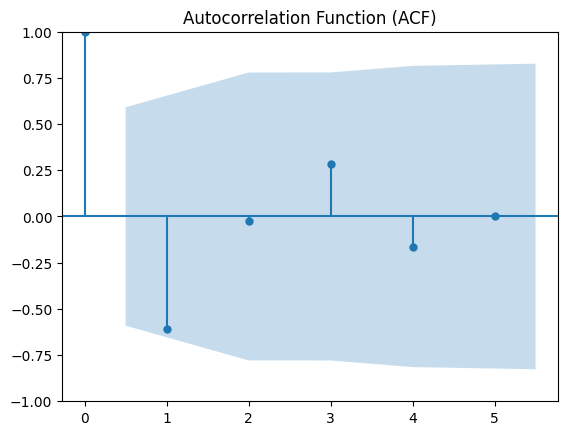

<Figure size 1200x600 with 0 Axes>

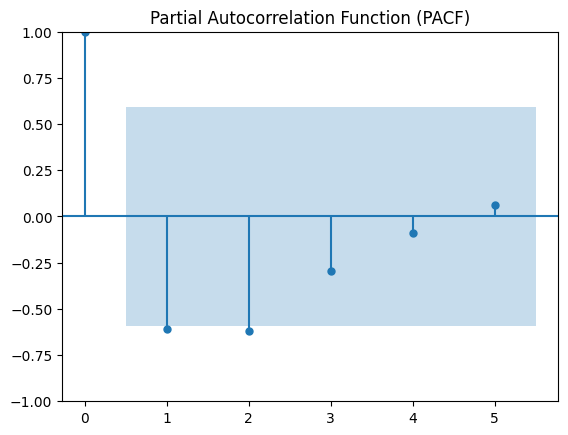


Fitting ARIMA model with order (3, 2, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   13
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 -67.706
Date:                Fri, 21 Mar 2025   AIC                            145.412
Time:                        19:55:07   BIC                            147.402
Sample:                             0   HQIC                           144.158
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1916      0.248     -4.795      0.000      -1.679      -0.705
ar.L2         -1.0444      0.44

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for અનાનસ saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_100bdc7c160cbdb4295a7b9fa243e26a.pkl
માલટા size:  90
True
Checking stationarity for the raw price data of માલટા:

ADF Test Results:
ADF Statistic: -0.1310
p-value: 0.9463
Critical Value 1%: -3.5138
Critical Value 5%: -2.8979
Critical Value 10%: -2.5862
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.7528
p-value: 0.0001
Critical Value 1%: -3.5138
Critical Value 5%: -2.8979
Critical Value 10%: -2.5862
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.7528
p-value: 0.0001
Critical Value 1%: -3.5138
Critical Value 5%: -2.8979
Critical Value 10%: -2.5862
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 4 at lags [1 3 5 9]
Significant spikes in PACF (p): 10 at lags [ 1  2  3  5  6  7  9 10 14 1

<Figure size 1200x600 with 0 Axes>

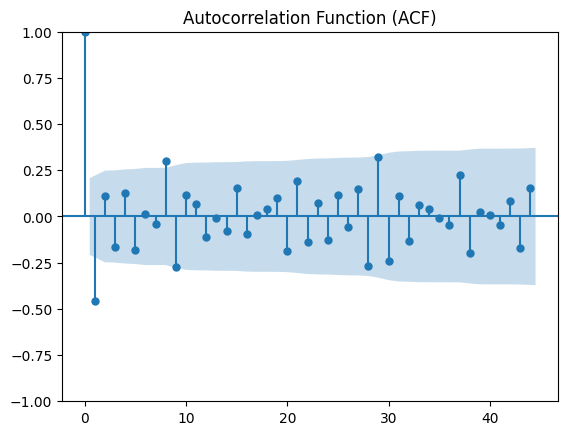

<Figure size 1200x600 with 0 Axes>

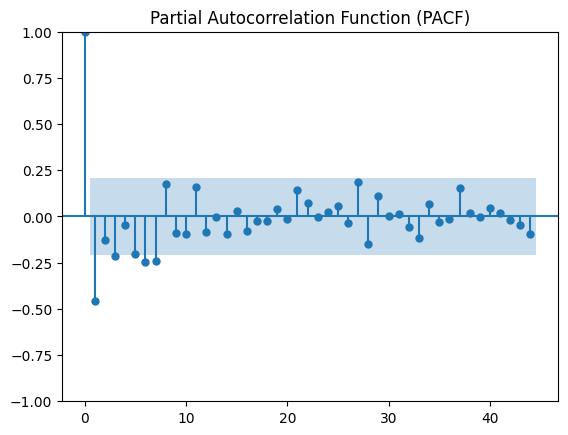


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   90
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -518.284
Date:                Fri, 21 Mar 2025   AIC                           1054.567
Time:                        19:55:10   BIC                           1076.965
Sample:                             0   HQIC                          1063.595
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7253      0.608     -1.193      0.233      -1.917       0.467
ar.L2         -0.7776      0.380     -2.044      0.041      -1.523      -0.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

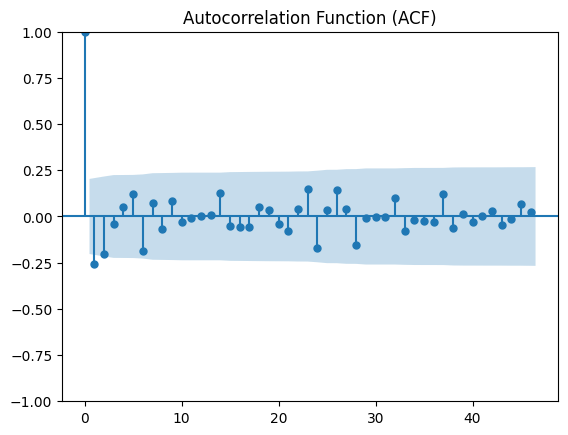

<Figure size 1200x600 with 0 Axes>

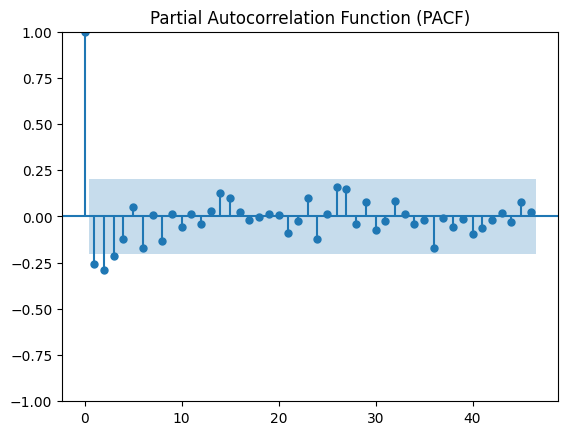


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   94
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -599.618
Date:                Fri, 21 Mar 2025   AIC                           1213.236
Time:                        19:55:11   BIC                           1230.965
Sample:                             0   HQIC                          1220.395
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0754      0.183     -5.861      0.000      -1.435      -0.716
ar.L2         -0.5759      0.271     -2.121      0.034      -1.108      -0.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

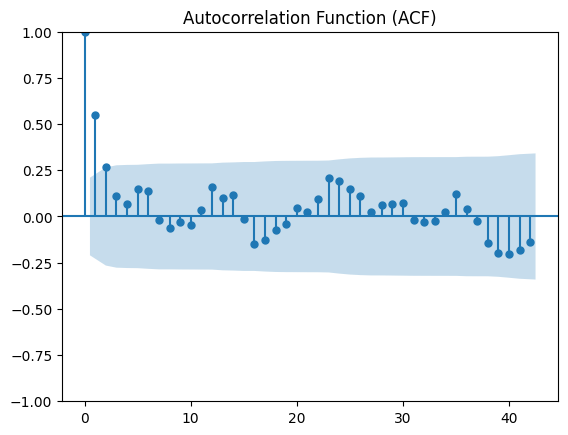

<Figure size 1200x600 with 0 Axes>

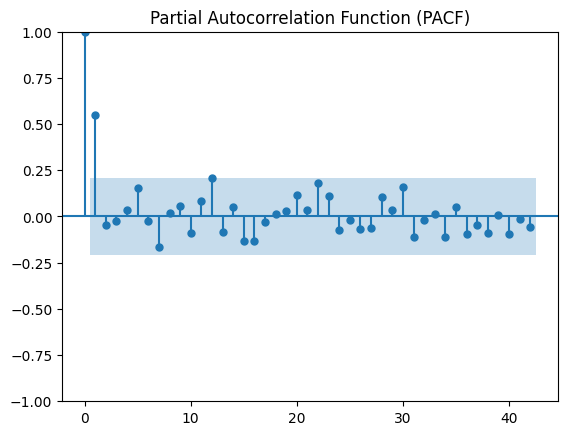


Fitting ARIMA model with order (4, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   87
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -540.395
Date:                Fri, 21 Mar 2025   AIC                           1094.790
Time:                        19:55:12   BIC                           1112.052
Sample:                             0   HQIC                          1101.741
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        716.2230     35.211     20.341      0.000     647.212     785.234
ar.L1          1.0250      1.320      0.777      0.437      -1.562       3.6

<Figure size 1200x600 with 0 Axes>

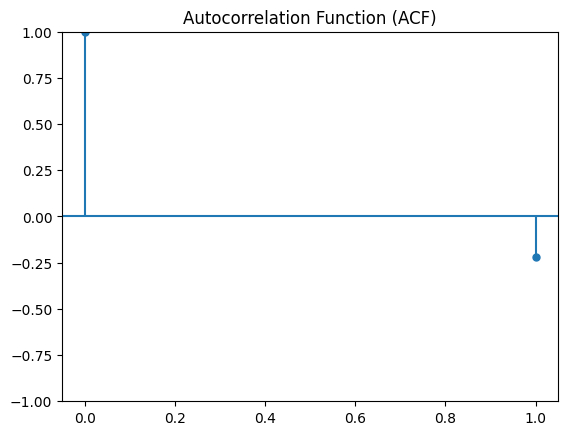

<Figure size 1200x600 with 0 Axes>

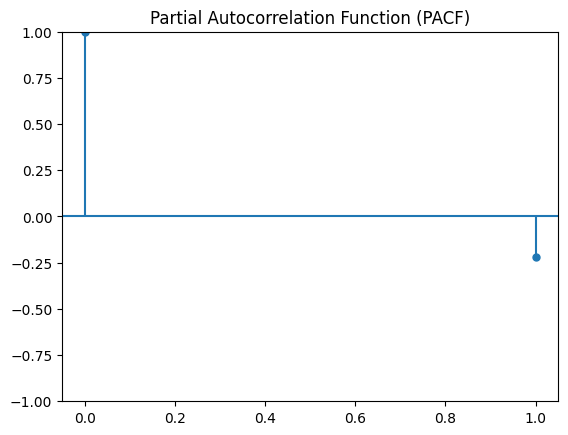


Fitting ARIMA model with order (0, 2, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    5
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 -31.462
Date:                Fri, 21 Mar 2025   AIC                             64.923
Time:                        19:55:12   BIC                             64.022
Sample:                             0   HQIC                            63.111
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.043e+07   2.52e+08      0.279      0.780   -4.24e+08    5.65e+08
Ljung-Box (L1) (Q):            

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

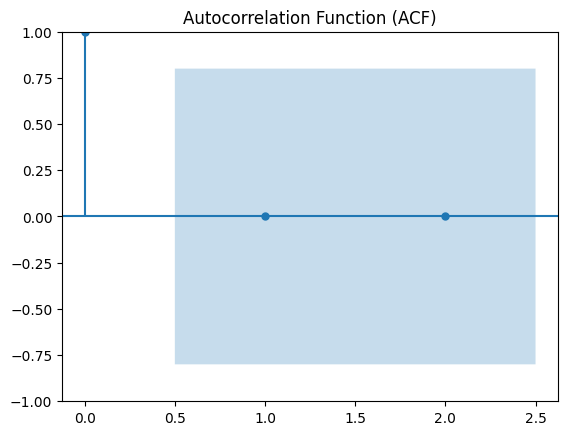

<Figure size 1200x600 with 0 Axes>

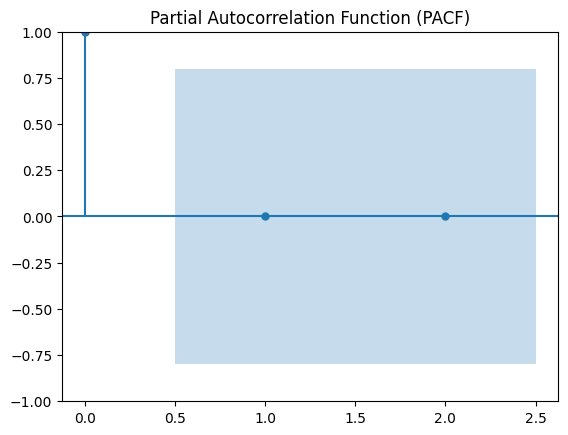


Fitting ARIMA model with order (0, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    6
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -51.899
Date:                Fri, 21 Mar 2025   AIC                            109.798
Time:                        19:55:12   BIC                            109.173
Sample:                             0   HQIC                           107.297
                                  - 6                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5650.8049    630.808      8.958      0.000    4414.443    6887.167
ma.L1          0.0121      9.51

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

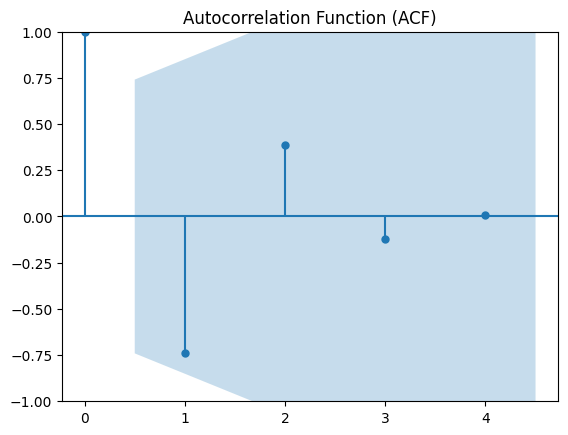

Can't plot the acf/pacf plots for હાફુસ કેરી due to Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 4 must be < 3.

Fitting ARIMA model with order (2, 3, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(2, 3, 1)   Log Likelihood                 -61.533
Date:                Fri, 21 Mar 2025   AIC                            131.067
Time:                        19:55:13   BIC                            130.850
Sample:                             0   HQIC                           128.392
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

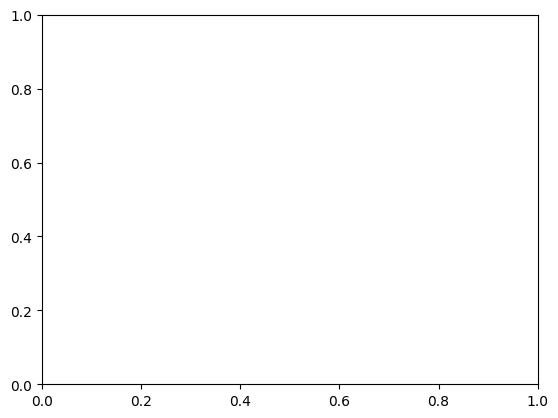

<Figure size 1200x600 with 0 Axes>

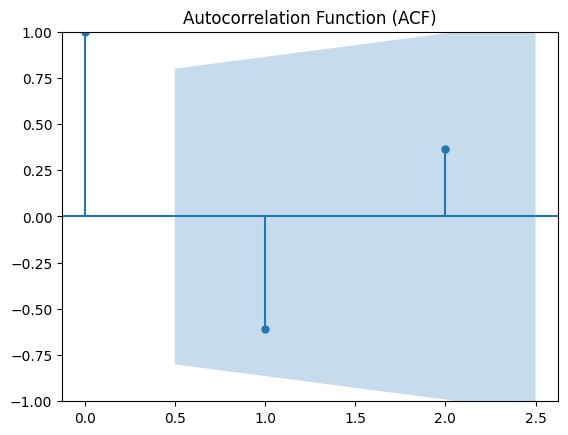

<Figure size 1200x600 with 0 Axes>

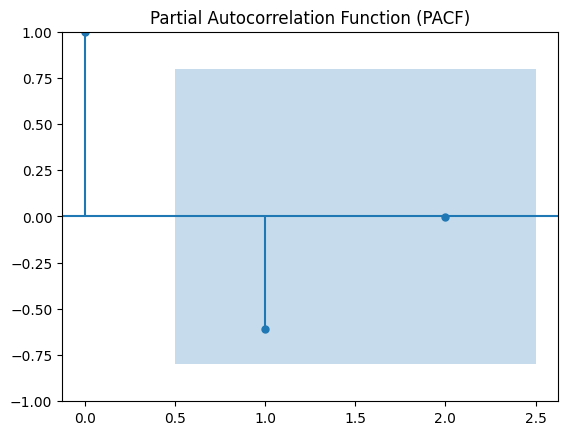


Fitting ARIMA model with order (1, 1, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    7
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.371
Date:                Fri, 21 Mar 2025   AIC                            102.742
Time:                        19:55:14   BIC                            102.117
Sample:                             0   HQIC                           100.241
                                  - 7                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0465      1.109     -0.042      0.967      -2.219       2.126
ma.L1         -1.0000      1.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for લાલબાગ કેરી saved as D:\APMC-price-predictor\ml_models\fruits_saved_models\arima_model_bd14fb01213332e76677dd9973ba9efa.pkl
બદામ કેરી size:  2
સૂ્દરી કેરી size:  2


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/fruits/fruits_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/fruits_saved_models"
filename = base_dir / "ml_models/fruits_saved_models/fruits_parameters.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("FRUITS_WEBPAGE_PATH"),
                                           os.getenv("FRUITS_DATE_PATH"),
                                           os.getenv("FRUITS_SUBMIT_BUTTON_PATH"),
                                           os.getenv("FRUITS_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
